# Hypothesis Test 3

## Data Collection

In [2]:
import psycopg2
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
from scipy import stats


In the cells below, we are creating a connection to our PSQL databased named 'soccer'. This allows us to select data from certain tables in PSQL and turn them into dataframes that we can later join or merge in order to explore our data. 

In [3]:
conn = psycopg2.connect('dbname=soccer')
cur = conn.cursor()
query = '''
SELECT *
FROM Country
;'''
cur.execute(query)

In [4]:
countries_data = cur.fetchall()
countries_df = pd.DataFrame(countries_data)
countries_df.columns = [i[0] for i in cur.description]
countries_df.head()

,id,name
0,1,Belgium
1,1729,England
2,4769,France
3,7809,Germany
4,10257,Italy


In [5]:
conn = psycopg2.connect('dbname=soccer')
cur = conn.cursor()
query = '''
SELECT *
FROM League
;'''
cur.execute(query)
league_data = cur.fetchall()
league_df = pd.DataFrame(league_data)
league_df.columns = [i[0] for i in cur.description]
league_df.head()

,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1
3,7809,7809,Germany 1. Bundesliga
4,10257,10257,Italy Serie A


In [6]:
conn = psycopg2.connect('dbname=soccer')
cur = conn.cursor()

query = '''
SELECT *
FROM Match
;'''

cur.execute(query)

match_data = cur.fetchall()
match_df = pd.DataFrame(match_data)
match_df.columns = [i[0] for i in cur.description]

In [7]:
conn = psycopg2.connect('dbname=soccer')
cur = conn.cursor()

query = '''
SELECT *
FROM Player_Attributes
;'''

cur.execute(query)

player_attrib_data = cur.fetchall()
player_attrib_df = pd.DataFrame(player_attrib_data)
player_attrib_df.columns = [i[0] for i in cur.description]


In [8]:
conn = psycopg2.connect('dbname=soccer')
cur = conn.cursor()

query = '''
SELECT *
FROM Team
;'''

cur.execute(query)

team_data = cur.fetchall()
team_df = pd.DataFrame(team_data)
team_df.columns = [i[0] for i in cur.description]


In [9]:
conn = psycopg2.connect('dbname=soccer')
cur = conn.cursor()

query = '''
SELECT *
FROM Team_Attributes
;'''

cur.execute(query)

team_attrib_data = cur.fetchall()
team_attrib_df = pd.DataFrame(team_attrib_data)
team_attrib_df.columns = [i[0] for i in cur.description]


In [10]:
player_df = pd.read_csv('player.csv')


 # HYPOTHESIS TEST 3


- There is no statisical difference in the defensive agressiveness between English and Spanish Teams
 
- HA: There is a difference in the defensive aggresiveness between English and Spanish Teams.

### Merging 

In [11]:
match_league_df = match_df.merge(league_df, left_on='league_id', right_on='id')

In [12]:
match_league_df['name'].value_counts()


France Ligue 1              3040
England Premier League      3040
Spain LIGA BBVA             3040
Italy Serie A               3017
Germany 1. Bundesliga       2448
Netherlands Eredivisie      2448
Portugal Liga ZON Sagres    2052
Poland Ekstraklasa          1920
Scotland Premier League     1824
Belgium Jupiler League      1728
Switzerland Super League    1422
Name: name, dtype: int64

In [13]:
team_attrib_by_league=team_attrib_df.join(match_league_df['name'], on='team_api_id', how='left')

In [14]:
defense = team_attrib_by_league[['defenceaggression', 'team_api_id', 'name']]
defense['name'].value_counts()

England Premier League      739
France Ligue 1              665
Poland Ekstraklasa           29
Portugal Liga ZON Sagres      8
Belgium Jupiler League        6
Name: name, dtype: int64

### We need to slice our dataframes in order to only have information about certain leagues:

In [15]:
#swiss_d = defense.loc[defense['defenseaggression'], 'name' == 'Switzerland Super League']
english_d = defense[defense['name'].str.contains("England")==True]
french_d = defense[defense['name'].str.contains("France")==True]


#### Create Numpy Arrays of Match/Defense Aggressiveness Data

In [16]:
english_array_df = english_d['defenceaggression']
english_array = np.array(english_array_df)
len(english_array)

739

In [17]:
french_array_df = french_d['defenceaggression']
french_array = np.array(french_array_df)
len(french_array)

665

## Two Sample Test Functions

In [18]:
def variance(sample):
    sample_mean = np.mean(sample)
    return sum([(i - sample_mean)**2 for i in sample])

def sample_variance(sample1, sample2):
    n_1, n_2 = len(sample1), len(sample2)
    var1, var2 = variance(sample1), variance(sample2)
    return (var1 + var2) / ((n_1 + n_2) - 2)

def twosample_tstatistic(expr, ctrl):
    expr_mean, ctrl_mean = np.mean(expr), np.mean(ctrl)
    n_e, n_c = len(expr), len(ctrl)
    samp_var = sample_variance(expr,ctrl)
    t = (expr_mean - ctrl_mean) / np.sqrt(samp_var * ((1/n_e)+(1/n_c)))
    return t


## England Vs French Defensive Aggressiveness

/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


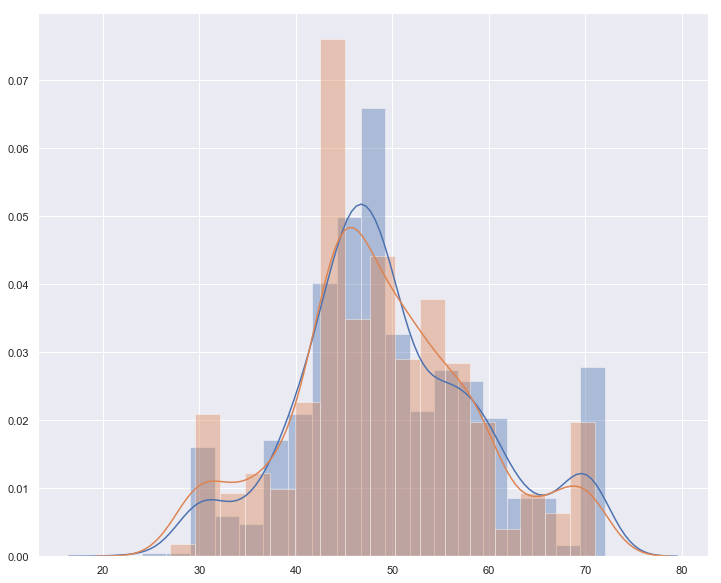

In [19]:
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(12,10)})
sns.distplot(english_array) # Blue distribution
sns.distplot(french_array) # Green distribution

In [20]:
sample_means_english = []
for _ in range(50):
    sample_mean = np.random.choice(english_array,size=50).mean()
    sample_means_english.append(sample_mean)
len(sample_means_english)

sample_means_french = []
for _ in range(50):
    sample_mean = np.random.choice(french_array,size=50).mean()
    sample_means_french.append(sample_mean)
len(sample_means_french)

50

In [21]:
sample_means_english
sample_means_french

[47.02,
 48.18,
 51.5,
 51.42,
 48.02,
 48.76,
 51.1,
 48.64,
 49.82,
 48.84,
 51.68,
 49.5,
 46.12,
 50.36,
 48.46,
 48.64,
 49.78,
 47.92,
 48.58,
 51.02,
 49.68,
 48.78,
 45.6,
 48.38,
 49.28,
 49.94,
 49.26,
 49.54,
 48.98,
 47.62,
 49.78,
 48.98,
 49.92,
 49.74,
 49.62,
 50.32,
 50.18,
 48.4,
 47.76,
 46.82,
 51.52,
 49.68,
 47.88,
 51.74,
 49.64,
 46.3,
 49.2,
 49.02,
 50.2,
 47.72]

In [22]:
t_stat = twosample_tstatistic(sample_means_english, sample_means_french)

t_stat

2.4720768673827362

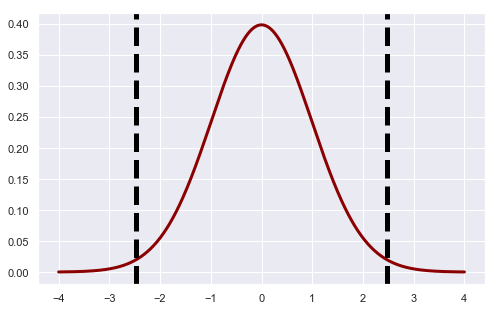

In [23]:
def visualize_t(t_stat, n_control, n_experimental):

    # initialize a matplotlib "figure"
    fig = plt.figure(figsize=(8,5))
    ax = fig.gca()
    # generate points on the x axis between -4 and 4:
    xs = np.linspace(-4, 4, 500)

    # use stats.t.pdf to get values on the probability density function for the t-distribution
    
    ys= stats.t.pdf(xs, (n_control+n_experimental-2), 0, 1)
    ax.plot(xs, ys, linewidth=3, color='darkred')

    ax.axvline(t_stat, color='black', linestyle='--', lw=5)
    ax.axvline(-t_stat, color='black', linestyle='--', lw=5)

    plt.show()
    return None

n_control = len(sample_means_english)
n_experimental = len(sample_means_french)
visualize_t(t_stat, n_control, n_experimental)

In [24]:
stats.ttest_ind(sample_means_english, sample_means_french)

Ttest_indResult(statistic=2.4720768673827362, pvalue=0.015156589077219057)

## Conclusion

There is no statistical significant difference in the defensive agressiveness between teams in the English and French soccer leagues, therefore we fail to reject the null hypothesis. 

# Hypothesis 4
## English vs France Cross Creation

In [25]:
team_attrib_by_league.groupby('name').mean()

,id,team_fifa_api_id,team_api_id,buildupplayspeed,buildupplaydribbling,buildupplaypassing,chancecreationpassing,chancecreationcrossing,chancecreationshooting,defencepressure,defenceaggression,defenceteamwidth
name,,,,,,,,,,,,
Belgium Jupiler League,1115.500000,874.000000,1601.000000,47.333333,48.000000,46.166667,55.500000,60.333333,53.500000,47.166667,47.333333,49.333333
England Premier League,723.814614,19511.317997,8353.744249,52.637348,48.166008,48.682003,52.416779,53.802436,54.297700,46.051421,49.671177,52.684709
France Ligue 1,746.327820,10798.747368,9978.723308,52.577444,48.884793,48.327820,51.935338,53.966917,53.502256,45.921805,48.993985,51.672180
Poland Ekstraklasa,725.965517,71989.103448,2068.275862,47.724138,53.250000,48.620690,52.517241,47.896552,59.000000,49.620690,45.344828,53.137931
Portugal Liga ZON Sagres,341.750000,111310.375000,4118.125000,50.500000,43.000000,44.375000,46.875000,58.500000,58.375000,47.875000,53.125000,58.250000


In [26]:
chance_creation = team_attrib_by_league[['chancecreationshooting', 'team_api_id', 'name']]
chance_creation['name'].value_counts()

England Premier League      739
France Ligue 1              665
Poland Ekstraklasa           29
Portugal Liga ZON Sagres      8
Belgium Jupiler League        6
Name: name, dtype: int64

In [27]:
english_cross = chance_creation[chance_creation['name'].str.contains("England")==True]
french_cross = chance_creation[chance_creation['name'].str.contains("France")==True]

In [28]:
english_cross_array = english_cross['chancecreationshooting']
english_array = np.array(english_cross_array)
len(english_cross_array)

french_cross_array = french_cross['chancecreationshooting']
french_array = np.array(french_cross_array)
len(french_cross_array)

665

In [29]:
sample_means_english_cross = []
for _ in range(50):
    sample_mean = np.random.choice(english_cross_array,size=50).mean()
    sample_means_english_cross.append(sample_mean)
len(sample_means_english_cross)

sample_means_french_cross= []
for _ in range(50):
    sample_mean = np.random.choice(french_cross_array,size=50).mean()
    sample_means_french_cross.append(sample_mean)
len(sample_means_french_cross)

50

In [30]:
t_stat = twosample_tstatistic(sample_means_english_cross, sample_means_french_cross)

t_stat

2.548120717923258

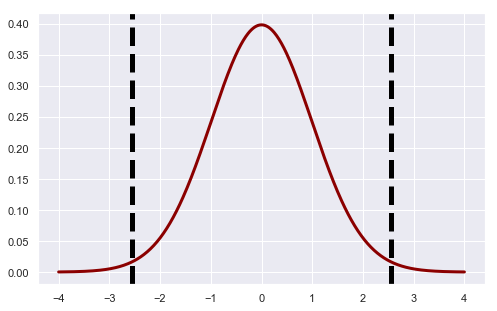

In [33]:
def visualize_t(t_stat, n_control, n_experimental):

    # initialize a matplotlib "figure"
    fig = plt.figure(figsize=(8,5))
    ax = fig.gca()
    # generate points on the x axis between -4 and 4:
    xs = np.linspace(-4, 4, 500)

    # use stats.t.pdf to get values on the probability density function for the t-distribution
    
    ys= stats.t.pdf(xs, (n_control+n_experimental-2), 0, 1)
    ax.plot(xs, ys, linewidth=3, color='darkred')

    ax.axvline(t_stat, color='black', linestyle='--', lw=5)
    ax.axvline(-t_stat, color='black', linestyle='--', lw=5)

    plt.show()
    return None

n_control = len(sample_means_english_cross)
n_experimental = len(sample_means_french_cross)
visualize_t(t_stat, n_control, n_experimental)

In [34]:
stats.ttest_ind(sample_means_english_cross, sample_means_french_cross)

Ttest_indResult(statistic=2.548120717923258, pvalue=0.012383924452850524)